# PCA

## setup

In [1]:
%load_ext autotime

In [2]:
from math import ceil
from time import time
import csv
import matplotlib.pylab as plt
import numpy as np
import os
import scipy
import scipy.linalg
import sklearn
import sklearn.decomposition
import sklearn.metrics
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

time: 1.15 s


## Example: 2D to 1D

In [3]:
# generate two clusters of 2d data points with some overlap
samples = np.vstack((
    np.random.default_rng().multivariate_normal(
        mean=np.array([0.0, 0.0]).T,
        cov=np.eye(2,2),
        size=(1000, )),
    np.random.default_rng().multivariate_normal(
        mean=np.array([3, 3]).T,
        cov=np.eye(2,2),
        size=(1000, ))
    ))

# center samples
samples = samples - samples.mean(axis=0)

time: 4.74 ms


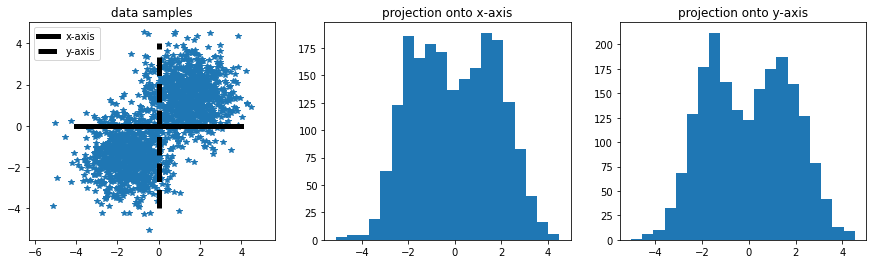

time: 450 ms


In [4]:
# projection to the x and y axes: clusters are partially hidden
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(15, 4)

# plot samples
ax[0].plot(samples[:, 0], samples[:, 1], '*')
ax[0].axis('equal')
ax[0].set_title('data samples')
# plot projection axes
ax[0].plot([-4, 4], [0, 0], 'k-', linewidth=5, label='x-axis')
ax[0].plot([0, 0], [-4, 4], 'k--', linewidth=5, label='y-axis')
ax[0].legend()

# x-axis projection
ax[1].hist(samples[:, 0], bins=20)
ax[1].set_title('projection onto x-axis')

# y-axis projection
ax[2].hist(samples[:, 1], bins=20)
ax[2].set_title('projection onto y-axis')

plt.show()

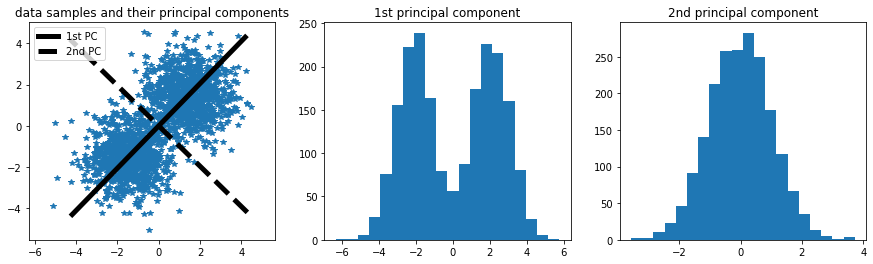

time: 558 ms


In [5]:
# compute eigenvalues and eigenvectors
vals, vecs = scipy.linalg.eigh(np.matmul(samples.T, samples))

fig, ax = plt.subplots(1, 3)
fig.set_size_inches(15, 4)

# plot samples and principal components
ax[0].plot(samples[:, 0], samples[:, 1], '*')
ax[0].axis('equal')
ax[0].set_title('data samples and their principal components')
# 1st principal axis
ax[0].plot([-6*vecs[0,1], 6*vecs[0, 1]], [-6*vecs[1,1], 6*vecs[1, 1]], 'k-', linewidth=5, label='1st PC')
# 2nd principal axis
ax[0].plot([-6*vecs[0,0], 6*vecs[0, 0]], [-6*vecs[1,0], 6*vecs[1, 0]], 'k--', linewidth=5, label='2nd PC')
ax[0].legend()

# projection to the first principal component - clusters are visible
ax[1].hist(np.matmul(samples, vecs[:, 1].reshape(-1, 1)), bins=20)
ax[1].set_title('1st principal component')

# projection to the second principal component - clusters are hidden
ax[2].hist(np.matmul(samples, vecs[:, 0].reshape(-1, 1)), bins=20)
ax[2].set_title('2nd principal component')

plt.show()

## Example: Uniform data

In [6]:
# generate some high-dimensional data from the same distribution
N = 100
samples = np.random.default_rng().multivariate_normal(
        mean=np.zeros(N).T,
        cov=np.eye(N,N),
        size=(1000, ))

# center samples
samples = samples - samples.mean(axis=0)

# compute covariance matrix
cov = np.matmul(samples.T, samples)

# compute eigenvalues
eigv, _ = scipy.linalg.eigh(cov)

# plot eigenvalues
iplot(dict(data=[
    go.Scatter(y=eigv[::-1]/eigv.sum())
]))

time: 289 ms


## Image classification

### Load dataset

In [7]:
# load mnist dataset
with open(os.path.join('..', 'data', 'mnist', 'mnist_train.csv'), 'r') as ifile:
    data = np.array([[int(cell) for cell in row] for row in csv.reader(ifile)])
    Y_train, X_train = data[:, 0], data[:, 1:]
with open(os.path.join('..', 'data', 'mnist', 'mnist_test.csv'), 'r') as ifile:
    data = np.array([[int(cell) for cell in row] for row in csv.reader(ifile)])
    Y_test, X_test = data[:, 0], data[:, 1:]

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((60000, 784), (60000,), (10000, 784), (10000,))

time: 14.9 s


In [8]:
# Alternative: fashion-mnist dataset
# load fashion-mnist dataset
#with open(os.path.join('..', 'data', 'fmnist', 'fashion_mnist_train.csv'), 'r') as ifile:
#    data = np.array([[int(cell) for cell in row] for row in csv.reader(ifile)])
#    Y_train, X_train = data[:, 0], data[:, 1:]
#with open(os.path.join('..', 'data', 'fmnist', 'fashion_mnist_test.csv'), 'r') as ifile:
#    data = np.array([[int(cell) for cell in row] for row in csv.reader(ifile)])
#    Y_test, X_test = data[:, 0], data[:, 1:]
#
#X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

time: 314 µs


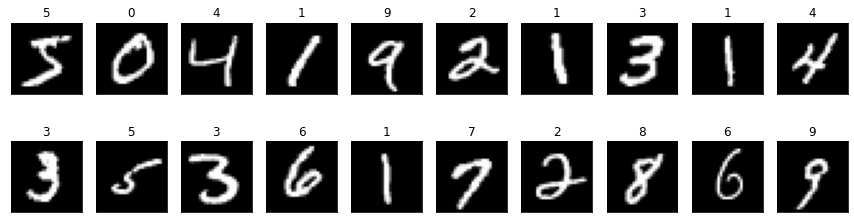

time: 746 ms


In [9]:
# show example images
rows, cols = 2, 10
fig, ax = plt.subplots(rows, cols)
fig.set_size_inches(15, 4)
for cax, ex, lbl in zip(ax.reshape(-1), X_train, Y_train):
    cax.imshow(ex.reshape(28, 28), cmap='gray')
    cax.get_xaxis().set_visible(False)
    cax.get_yaxis().set_visible(False)
    cax.set_title(lbl)
plt.show()

### Baseline: Nearest-Neighbour classifier in the image space

NN: We assign a testing sample the label of its closest training sample.

In [10]:
# no preparation needed
t_baseline_train = 0

time: 388 µs


In [11]:
pred_bs = [] # store predictions per testing sample

# start the clock
t_baseline_eval = time()

# classify all testing data samples
for batch in sklearn.utils.gen_batches(len(X_test), 100):
    # fetch test batch
    X_batch = X_test[batch]
    Y_batch = Y_test[batch]
    
    # classify in data space w.r.t. training samples
    # uses the euclidean distance
    dist = sklearn.metrics.pairwise_distances(X_batch, X_train)
    
    # find nearest neighbour's label
    nn = Y_train[dist.argmin(axis=1)]
    
    # store predictions
    pred_bs.append(nn)

# stop the clock
t_baseline_eval = time() - t_baseline_eval

# collect predictions in one array
pred_bs = np.hstack(pred_bs)

time: 1min 4s


In [12]:
# accuracy in %
100 * sklearn.metrics.accuracy_score(Y_test, pred_bs)

96.91

time: 7.55 ms


### Pre-study: Cutoff

In [13]:
# center training samples
Xc = X_train - X_train.mean(axis=0)

# compute the sample covariance matrix
cov = np.matmul(Xc.T, Xc)

# compute eigenvalues
eigv, _ = scipy.linalg.eigh(cov)

# sort eigenvalues in descending order
eigv = eigv[::-1]

# normalize eigenvalues
eigv = eigv / eigv.sum()

time: 1.38 s


In [14]:
iplot(dict(data=[
    go.Scatter(
        x=list(range(1,1+len(eigv))),
        y=eigv,
        name='Eigenvalues',
        customdata=100*eigv.cumsum(),
        hovertemplate='Eigenvalue = %{y}<br>Retained Var = %{customdata:0.3f}%',
    )],
    layout=go.Layout(
        title='Eigenvalues, normalized',
        xaxis=dict(title='Index'),
        yaxis=dict(title='Eigenvalue'),
    )))

time: 284 ms


In [15]:
#plt.plot(eigv)
#plt.xlim(-1, 180)
#plt.ylim(-0.001, 0.08)
#plt.savefig('pca-eigv.svg')
#plt.title('Eigenvalues, normalized')
#plt.show()

time: 301 µs


### Train and analyze PCA

In [16]:
# start the clock
t_pca_train = time()

# set the number of dimensions we want to keep
n_components = 40

# initialize the PCA model
model = sklearn.decomposition.PCA(n_components=n_components)

# train on training samples
model.fit(X_train)

# stop the clock
t_pca_train = time() - t_pca_train

time: 8.9 s


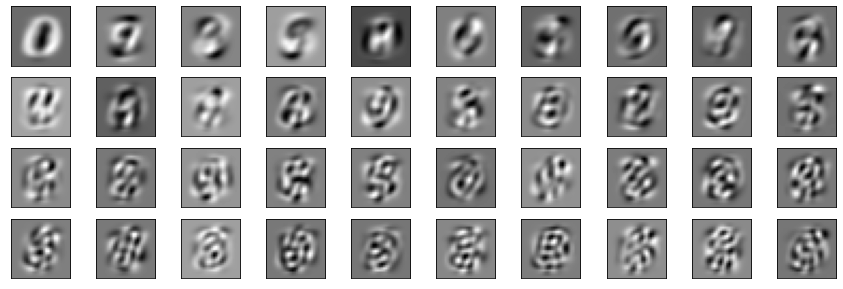

time: 1.59 s


In [17]:
# plot eigenvectors

# set up a (cols x rows)-grid
N = len(model.components_)
cols = 10
rows = int(ceil(N / cols))

fig, ax = plt.subplots(rows, cols)
fig.set_size_inches(15, 5)

# plot components as images
for cax, comp in zip(ax.reshape(-1), model.components_):
    cax.imshow(comp.reshape(28, 28), cmap='gray')
    cax.get_xaxis().set_visible(False)
    cax.get_yaxis().set_visible(False)

# plot a placeholder in any remaining grid cells
for cax in ax.reshape(-1)[N:]:
    cax.imshow(np.array([255]).reshape(1,1), cmap='gray', vmin=0, vmax=255)
    cax.get_xaxis().set_visible(False)
    cax.get_yaxis().set_visible(False)

plt.show()

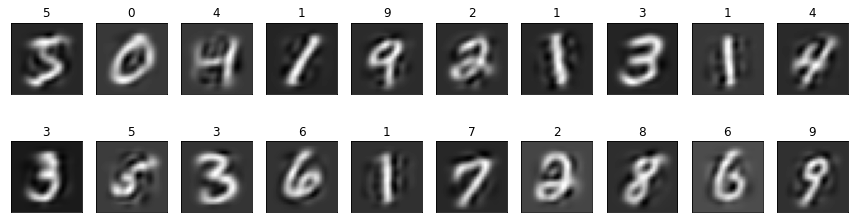

time: 935 ms


In [18]:
# show reconstructed images
rows, cols = 2, 10
fig, axes = plt.subplots(rows, cols)
fig.set_size_inches(15, 4)

# plot reconstructed image
for ax, sample, label in zip(axes.reshape(-1), X_train, Y_train):
    # perform PCA on sample
    compressed = model.transform(sample.reshape(1, -1))
    # perform inverse on latent sample
    reconstructed = model.inverse_transform(compressed)
    # show reconstructed sample as image
    ax.imshow(reconstructed.reshape(28, 28), cmap='gray')
    # some style
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(label)

plt.show()

### Nearest-Neighbour classifier in the latent space

The nearest neighbour classification works in the same way as for the baseline, however now the comparison is performed in the latent space (i.e. PCA subspace).

In [19]:
pred_pca = [] # store predictions per testing sample

# start the clock
t_pca_eval = time()

# neighbour references from training set
base = model.transform(X_train)

for batch in sklearn.utils.gen_batches(len(X_test), 100):
    # fetch test batch
    X_batch = X_test[batch]
    Y_batch = Y_test[batch]
    
    # project to latent space
    hidden = model.transform(X_batch)
    
    # classify in latent space w.r.t. training samples
    # uses the euclidean distance
    dist = sklearn.metrics.pairwise_distances(hidden, base)
    
    # find nearest neighbour's label
    nn = Y_train[dist.argmin(axis=1)]
    
    # store predictions
    pred_pca.append(nn)

# stop the clock
t_pca_eval = time() - t_pca_eval
    
# collect predictions in one array
pred_pca = np.hstack(pred_pca)

time: 28 s


In [20]:
# accuracy in %
100 * sklearn.metrics.accuracy_score(Y_test, pred_pca)

97.34

time: 18.2 ms


### Comparison: PCA vs. Baseline

In [21]:
# accuracy
print('Baseline: {:0.3f}%'.format(100 * sklearn.metrics.accuracy_score(Y_test, pred_bs)))
print('PCA+NN  : {:0.3f}%'.format(100 * sklearn.metrics.accuracy_score(Y_test, pred_pca)))
print()

Baseline: 96.910%
PCA+NN  : 97.340%

time: 14 ms


In [22]:
# time
print('Baseline: {:0.3f}s'.format(t_baseline_train + t_baseline_eval))
print('PCA+NN  : {:0.3f}s'.format(t_pca_train + t_pca_eval))
print()

Baseline: 64.477s
PCA+NN  : 36.906s

time: 4.23 ms


In [23]:
# space
print('BS  Image: 100%')
print('PCA Image: {:0.3f}%'.format(100 * n_components / X_train.shape[1]))
print()

print('BS  training data: 100%')
print('PCA training data: {:0.3f}%'.format(
    # principal vectors + compressed images
    (model.components_.shape[0] * model.components_.shape[1] + X_train.shape[0] * n_components) / \
    # training dataset size
    (X_train.shape[0] * X_train.shape[1])))
print()

BS  Image: 100%
PCA Image: 5.102%

BS  training data: 100%
PCA training data: 0.052%

time: 5.34 ms


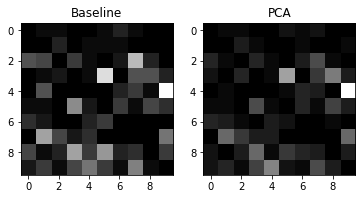

time: 256 ms


In [24]:
# misclassifications (w/o TP). read as: x=9, y=4: Number of true "4" predicted as "9"
fig, ax = plt.subplots(1, 2)
mask = (np.ones((10,10)) - np.eye(10,10))
ax[0].imshow(sklearn.metrics.confusion_matrix(Y_test, pred_bs) * mask, cmap='gray')
ax[0].set_title('Baseline')
ax[1].imshow(sklearn.metrics.confusion_matrix(Y_test, pred_pca) * mask, cmap='gray')
ax[1].set_title('PCA')

plt.show()